In [86]:
import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from datetime import timedelta
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221120'
}

q = '''
SELECT
    toString(cohort) cohort,
    toString(day) day,
    count(user_id) AS users,
    source
FROM (
    SELECT *
    FROM (
        SELECT
            user_id,
            min(toDate(time)) AS cohort,
            source
        FROM simulator_20221120.feed_actions
        GROUP BY user_id, source) t1
        JOIN (
            SELECT DISTINCT
                user_id,
                toDate(time) AS day
            FROM
                simulator_20221120.feed_actions) t2
            USING user_id
            WHERE cohort >= today() - 20
            )
GROUP BY
    cohort, day, source
'''

df = pandahouse.read_clickhouse(q, connection=connection)

print(df.head())

       cohort         day  users   source
0  2022-11-27  2022-12-02    369  organic
1  2022-11-18  2022-11-27    366  organic
2  2022-11-19  2022-12-05    182      ads
3  2022-12-03  2022-12-03   1275      ads
4  2022-11-17  2022-11-29    240  organic


In [65]:
# преобразуем даты

df['cohort'] = pd.to_datetime(df['cohort'])
df['day'] = pd.to_datetime(df['day'])

In [66]:
df.head()

,cohort,day,users,source
0,2022-11-27,2022-12-02,369,organic
1,2022-11-18,2022-11-27,366,organic
2,2022-11-19,2022-12-05,182,ads
3,2022-12-03,2022-12-03,1275,ads
4,2022-11-17,2022-11-29,240,organic


In [67]:
# сортируем

df = df.sort_values(by=['cohort', 'day', 'source'])

In [68]:
# создаем два датафрейма по типу источика

df_ads_source = df.query("source == 'ads'").drop(columns='source')
df_org_source = df.query("source == 'organic'").drop(columns='source')

In [69]:
df_ads_source.head()

,cohort,day,users
127,2022-11-17,2022-11-17,883
180,2022-11-17,2022-11-18,316
227,2022-11-17,2022-11-19,299
84,2022-11-17,2022-11-20,276
93,2022-11-17,2022-11-21,220


In [70]:
df_org_source.head()

,cohort,day,users
276,2022-11-17,2022-11-17,1086
337,2022-11-17,2022-11-18,433
286,2022-11-17,2022-11-19,400
433,2022-11-17,2022-11-20,395
422,2022-11-17,2022-11-21,365


In [71]:
# добавляем period_number

df_ads_source['period_number'] = (df_ads_source['day'] - df_ads_source['cohort']).apply(attrgetter('days'))
df_org_source['period_number'] = (df_org_source['day'] - df_org_source['cohort']).apply(attrgetter('days'))

In [72]:
# преобразуем кзначение корорты из даты в текст, для удобного отображения на тепловой диаграмме

df_ads_source['cohort'] = df_ads_source['cohort'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_org_source['cohort'] = df_org_source['cohort'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [74]:
df_org_source.dtypes

cohort                   object
day              datetime64[ns]
users                    uint64
period_number             int64
dtype: object

In [75]:
# cледующий шаг - развернуть таблицу, при помощи pivot, таким образом,
# чтобы каждая строка содержала информацию о данной когорте,
# а каждый столбец содержал значения за определенный период.

df_ads_source_pivot = df_ads_source.pivot_table(index = 'cohort', columns = 'period_number', values = 'users')
df_org_source_pivot = df_org_source.pivot_table(index = 'cohort', columns = 'period_number', values = 'users')

In [76]:
# Чтобы получить retention matrix, нам нужно разделить значения каждой строки на первое значение строки,
# которое фактически является размером когорты cohort_size — всех пользователей, совершивших свою первую покупку в данный день.

cohort_size_ads = df_ads_source_pivot.iloc[:,0]
cohort_size_org = df_org_source_pivot.iloc[:,0]

retention_matrix_ads = df_ads_source_pivot.divide(cohort_size_ads, axis = 0)
retention_matrix_org = df_ads_source_pivot.divide(cohort_size_org, axis = 0)


In [77]:
# retention matrix ads users

retention_matrix_ads

period_number,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
cohort,,,,,,,,,,,,,,,,,,,,,
2022-11-17,1.0,0.357871,0.338618,0.312571,0.249151,0.259343,0.259343,0.173273,0.195923,0.229898,...,0.161948,0.147225,0.154020,0.140430,0.138165,0.116648,0.104190,0.109853,0.093998,0.082673
2022-11-18,1.0,0.380037,0.355311,0.353480,0.332418,0.304945,0.215201,0.255495,0.260989,0.242674,...,0.200549,0.205128,0.183150,0.139194,0.143773,0.118132,0.107143,0.132784,0.096154,NaN
2022-11-19,1.0,0.465604,0.383389,0.371644,0.402685,0.275168,0.317114,0.311242,0.286913,0.246644,...,0.212248,0.191275,0.174497,0.190436,0.160235,0.152685,0.140101,0.113255,NaN,NaN
2022-11-20,1.0,0.400385,0.374398,0.358037,0.247353,0.309913,0.292589,0.288739,0.256015,0.232916,...,0.191530,0.166506,0.185756,0.145332,0.145332,0.127045,0.123195,NaN,NaN,NaN
2022-11-21,1.0,0.446948,0.409390,0.311737,0.324883,0.358685,0.287324,0.294836,0.259155,0.264789,...,0.206573,0.190610,0.178404,0.182160,0.144601,0.123005,NaN,NaN,NaN,NaN
2022-11-22,1.0,0.242938,0.190678,0.242938,0.221751,0.189266,0.207627,0.210452,0.186441,0.138418,...,0.134181,0.118644,0.111582,0.088983,0.057910,NaN,NaN,NaN,NaN,NaN
2022-11-23,1.0,0.190083,0.241322,0.213223,0.168595,0.176860,0.171901,0.191736,0.153719,0.128926,...,0.100826,0.097521,0.090909,0.064463,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-24,1.0,0.368831,0.292208,0.310390,0.279221,0.280519,0.264935,0.267532,0.236364,0.220779,...,0.184416,0.155844,0.145455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-25,1.0,0.347650,0.346029,0.342788,0.320908,0.304700,0.293355,0.266613,0.232577,0.224473,...,0.192869,0.145057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


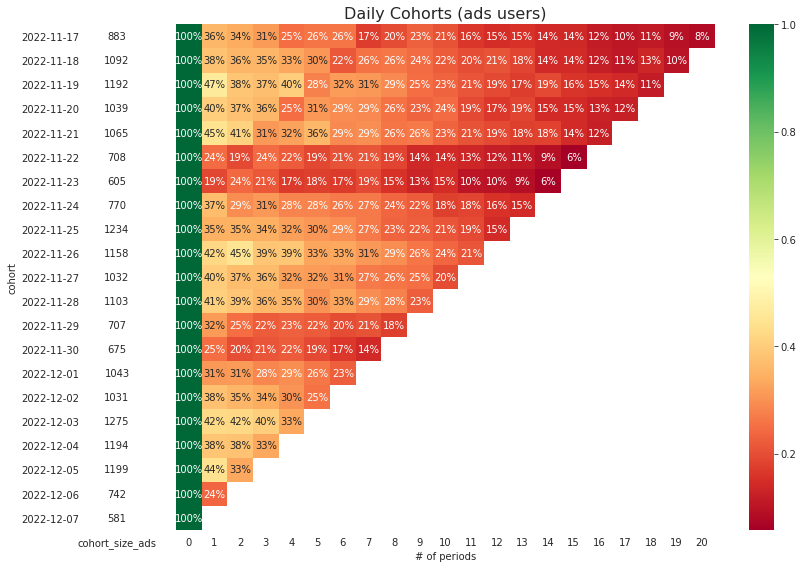

In [78]:
# строим график - тепловую карту для ads users

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention_matrix_ads
    sns.heatmap(retention_matrix_ads, 
                mask=retention_matrix_ads.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Daily Cohorts (ads users)', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_ads).rename(columns={0: 'cohort_size_ads'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [79]:
# retention matrix organic users

retention_matrix_org

period_number,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
cohort,,,,,,,,,,,,,,,,,,,,,
2022-11-17,0.813076,0.290976,0.275322,0.254144,0.202578,0.210866,0.210866,0.140884,0.159300,0.186924,...,0.131676,0.119705,0.125230,0.114180,0.112339,0.094843,0.084715,0.089319,0.076427,0.067219
2022-11-18,0.923077,0.350803,0.327980,0.326289,0.306847,0.281488,0.198648,0.235841,0.240913,0.224007,...,0.185123,0.189349,0.169062,0.128487,0.132713,0.109045,0.098901,0.122570,0.088757,NaN
2022-11-19,0.909924,0.423664,0.348855,0.338168,0.366412,0.250382,0.288550,0.283206,0.261069,0.224427,...,0.193130,0.174046,0.158779,0.173282,0.145802,0.138931,0.127481,0.103053,NaN,NaN
2022-11-20,0.927679,0.371429,0.347321,0.332143,0.229464,0.287500,0.271429,0.267857,0.237500,0.216071,...,0.177679,0.154464,0.172321,0.134821,0.134821,0.117857,0.114286,NaN,NaN,NaN
2022-11-21,0.943313,0.421612,0.386182,0.294066,0.306466,0.338353,0.271036,0.278122,0.244464,0.249779,...,0.194863,0.179805,0.168291,0.171833,0.136404,0.116032,NaN,NaN,NaN,NaN
2022-11-22,0.976552,0.237241,0.186207,0.237241,0.216552,0.184828,0.202759,0.205517,0.182069,0.135172,...,0.131034,0.115862,0.108966,0.086897,0.056552,NaN,NaN,NaN,NaN,NaN
2022-11-23,0.905689,0.172156,0.218563,0.193114,0.152695,0.160180,0.155689,0.173653,0.139222,0.116766,...,0.091317,0.088323,0.082335,0.058383,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-24,0.888120,0.327566,0.259516,0.275663,0.247982,0.249135,0.235294,0.237601,0.209919,0.196078,...,0.163783,0.138408,0.129181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-25,0.990369,0.344302,0.342697,0.339486,0.317817,0.301766,0.290530,0.264045,0.230337,0.222311,...,0.191011,0.143660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


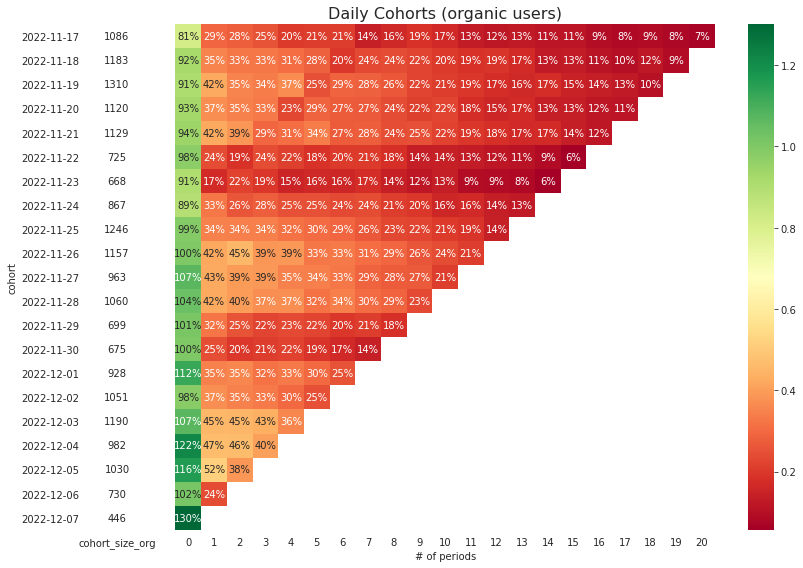

In [54]:
# строим график - тепловую карту для organic users

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention_matrix_org
    sns.heatmap(retention_matrix_org, 
                mask=retention_matrix_org.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Daily Cohorts (organic users)', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_org).rename(columns={0: 'cohort_size_org'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [88]:
#  для дальнейшей оценки статистической значимости различий двух групп, расчитаем медианное значение retention каждого дня

ads = retention_matrix_ads.drop(columns=[0]).median().reset_index().rename(columns={'period_number': 'day', 0: 'retention'})
org = retention_matrix_org.drop(columns=[0]).median().reset_index().rename(columns={'period_number': 'day', 0: 'retention'})

<AxesSubplot:xlabel='day', ylabel='retention'>

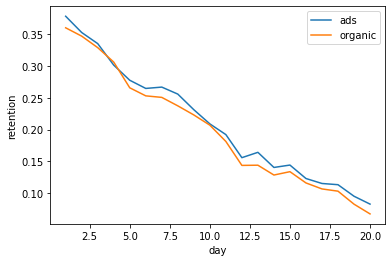

In [90]:
# визуализируем

sns.lineplot(data=ads, x='day', y='retention', label='ads')
sns.lineplot(data=org, x='day', y='retention', label='organic')

In [91]:
# U-тест

mannwhitneyu(ads['retention'],org['retention'])

MannwhitneyuResult(statistic=219.0, pvalue=0.6167746941014318)

In [ ]:
Нет оснований отклонить H0 о равенстве средних двух групп